# Collaboration and Competition

---

Congratulations for completing the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control agents in a more challenging environment, where the goal is to train a team of agents to play soccer.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Soccer.app"`
- **Windows** (x86): `"path/to/Soccer_Windows_x86/Soccer.exe"`
- **Windows** (x86_64): `"path/to/Soccer_Windows_x86_64/Soccer.exe"`
- **Linux** (x86): `"path/to/Soccer_Linux/Soccer.x86"`
- **Linux** (x86_64): `"path/to/Soccer_Linux/Soccer.x86_64"`
- **Linux** (x86, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86"`
- **Linux** (x86_64, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86_64"`

For instance, if you are using a Mac, then you downloaded `Soccer.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Soccer.app")
```

In [2]:
env = UnityEnvironment(file_name="Soccer_Linux/Soccer.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [3]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


**&rightarrow; Note:** Action size of goalie agents ant striker agents are different!

### 3. MADDPG
#### Implement an Agent

MADDPG is implemented in maddpg/maddpg.py. It uses the the DDPG agent in maddpg/ddpg_agent.py and the neural network architectures in model.py.

#### Train the Agent

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib notebook

def init_plot():
    fig,ax = plt.subplots(1,1)
    ax.grid(True)
    ax.set_xlabel('Episode #')
    return fig, ax

def live_plot(fig, ax, data_dict, figsize=(7,5), title=''):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(list(range(len(data_dict[line.get_label()]))))
            line.set_ydata(data_dict[line.get_label()])
        ax.set_xlim(0, len(data_dict[line.get_label()]))
        
    else:
        for label,data in data_dict.items():
            line, = ax.plot(data)
            line.set_label(label)
            ax.legend()
        ax.set_ylim(-0.5, 3.)
    
    fig.canvas.draw()

<IPython.core.display.Javascript object>


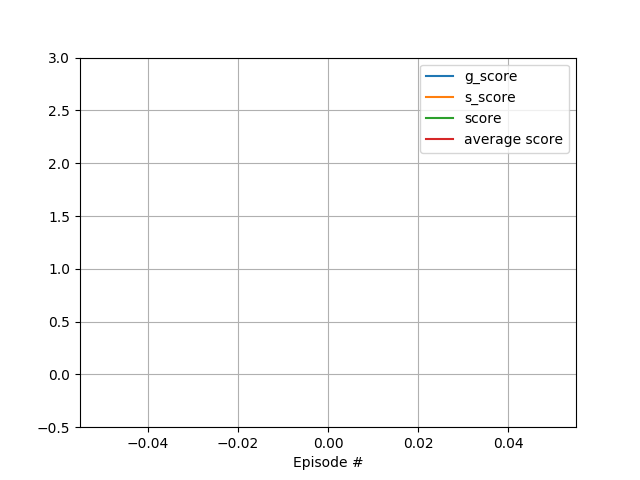

Episode 1	Average Score: 0.00

KeyboardInterrupt: 

In [6]:
import time
import torch
from collections import defaultdict, deque

from maddpg.maddpg import MADDPG
from maddpg.ddpg_agent import Agent

def train(n_episodes=2000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_for_visualization = defaultdict(list)
    max_score = 0.
    
    fig, ax = init_plot()
    
    for i_episode in range(1, n_episodes + 1):
        episode_start = time.time()
        
        env_info = env.reset(train_mode=False)                 # reset the environment    
        g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
        s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
        g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
        s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
        
        while True:
            # get agent actions
            states = np.vstack([g_states, s_states])
            actions = agent.act(states, discretize_actions=True)
            
            # step environment
            g_actions = actions[0]
            s_actions = actions[1]
            env_actions = dict(zip([g_brain_name, s_brain_name], 
                                   [g_actions, s_actions]))
            env_info = env.step(env_actions)
            
            # extract next states and rewards
            g_next_states = env_info[g_brain_name].vector_observations
            s_next_states = env_info[s_brain_name].vector_observations
            next_states = np.vstack([g_next_states, s_next_states])
            
            g_rewards = env_info[g_brain_name].rewards
            s_rewards = env_info[s_brain_name].rewards
            rewards = np.vstack([g_rewards, s_rewards])
            
            done = np.any(env_info[g_brain_name].local_done)
            
            # step agents
            actions = actions.reshape(num_all_agents, -1)
            rewards = rewards.reshape(num_all_agents, -1)
            agent.step(states, actions, rewards, next_states, done, discretize_actions=True)
            
            # update scores and states
            g_scores += g_rewards
            s_scores += s_rewards
            
            g_states = g_next_states
            s_states = s_next_states
            
            if done:
                break
                
        # save score
        score = (np.mean(g_scores).astype(float) + np.mean(s_scores).astype(float)) / 2.
        scores_deque.append(score)
        scores_for_visualization["g_score"].append(np.sum(g_rewards))
        scores_for_visualization["s_score"].append(np.sum(s_rewards))
        scores_for_visualization["score"].append(score)
        scores_for_visualization["average score"].append(np.mean(scores_deque))

        # print current performance
        live_plot(fig, ax, scores_for_visualization)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")

        if scores_for_visualization["average score"][-1] > max_score:
            max_score = scores_for_visualization["average score"][-1]
            if max_score > 1.5:
                torch.save(agent.actor_local.state_dict(), 'ddpg/ddpg_checkpoint_actor_score_' + str(max_score) + '.pth')
                torch.save(agent.critic_local.state_dict(), 'ddpg/ddpg_checkpoint_critic_score_' + str(max_score) + '.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tDuration: {:.6f} Min'.format(i_episode, 
                                                                                      np.mean(scores_deque), 
                                                                                     (time.time() - episode_start) / 60. * print_every
                                                                                     ))
            
    return

seed=42
batch_size=256
num_all_agents = num_g_agents + num_s_agents
action_size_all_agents = (num_g_agents * g_action_size) + (num_s_agents * s_action_size)

agents = []
agents.append(Agent(g_state_size, g_action_size, num_g_agents, num_all_agents, seed, 
                    batch_size, discrete_actions=True))
agents.append(Agent(s_state_size, s_action_size, num_s_agents, num_all_agents, seed, 
                    batch_size, discrete_actions=True))

agent = MADDPG(agents, seed=42, batch_size=256)
scores = train()

In [ ]:
for i in range(2):                                         # play game for 2 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    while True:
        # select actions and send to environment
        g_actions = np.random.randint(g_action_size, size=num_g_agents)
        s_actions = np.random.randint(s_action_size, size=num_s_agents)
        actions = dict(zip([g_brain_name, s_brain_name], 
                           [g_actions, s_actions]))
        env_info = env.step(actions)                       
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        
        # get reward and update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  
        
        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
        # exit loop if episode finished
        if done:                                           
            break
    print('Scores from episode {}: {} (goalies), {} (strikers)'.format(i+1, g_scores, s_scores))

#### Watch a Smart Agent!

In [ ]:
import torch

from ddpg.ddpg_agent import Agent

agent = Agent(state_size, action_size, num_agents, seed=0, batch_size=256)

agent.actor_local.load_state_dict(torch.load('ddpg/ddpg_checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('ddpg/ddpg_checkpoint_critic.pth'))

env_info  = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    agent.step(states, actions, rewards, next_states, dones)

    states = next_states
    if np.any(dones):
        break

In [ ]:
env.close()